In [1]:
import trainer
from utils import get_batch_classifier, slanted_triangular_learning_rate
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

In [2]:
with open('SentimentAnalysis/word2idx.json', 'r') as inp:
    word2idx = json.load(inp)
with open('SentimentAnalysis/char2idx.json', 'r') as inp:
    char2idx = json.load(inp)

In [3]:
VERSION = '102_sa'
params = dict(
    model_configs = {
      "rnn_layers":[
          {
             "units": 1024,
             "drop_i": 0.2,
             "wdrop": 0.4,
             "drop_o": 0.2
          },
          {
             "units": 1024,
             "wdrop": 0.4,
             "drop_o": 0.2
          },
          {
             "units": 1024,
             "drop_o": 0.2,
             "wdrop": 0.4
          }
],
       "vocab_size": len(word2idx) + 1,
       "drop_e": 0.0,
       "char_vocab_size": len(char2idx) + 1,
       "char_cnn_options": {
           "layers": [
                [1, 16],
                [2, 16],
                [3, 32],
                [4, 64],
                [5, 128],
                [6, 256],
                [7, 512]
           ],
           "n_highways": 2
       },
       "char_vec_size": 16,
       "projection_dims": 512,
       "skip_connection": True
    },
    optimizer = {'name': 'adamw', 'params': {'beta1': 0.9, 'beta2': 0.999, 'weight_decay': 0.0}},
    negative_samples = 10240,
    wdecay = 0.0,
    alpha = 1e-6,
    beta = 1e-6,
    clip_norm = 25.0,
    clip_min = -100.0, clip_max = 100.0,
    bptt = 70,
    use_ema = False,
    save_freq = 50,
    log_path = '{}/logs'.format(VERSION),
    train_summary_dir = '{}/train_summary/'.format(VERSION),
    test_summary_dir = '{}/test_summary/'.format(VERSION),
    checkpoint_dir = '{}/checkpoints/'.format(VERSION)
)

my_trainer = trainer.Trainer(**params, fine_tune=True)

my_trainer.logger.info('Trainer params {}'.format(params))

tf.reset_default_graph()

Trainer params {'model_configs': {'rnn_layers': [{'units': 1024, 'drop_i': 0.2, 'wdrop': 0.4, 'drop_o': 0.2}, {'units': 1024, 'wdrop': 0.4, 'drop_o': 0.2}, {'units': 1024, 'drop_o': 0.2, 'wdrop': 0.4}], 'vocab_size': 153531, 'drop_e': 0.0, 'char_vocab_size': 1005, 'char_cnn_options': {'layers': [[1, 16], [2, 16], [3, 32], [4, 64], [5, 128], [6, 256], [7, 512]], 'n_highways': 2}, 'char_vec_size': 16, 'projection_dims': 512, 'skip_connection': True}, 'optimizer': {'name': 'adamw', 'params': {'beta1': 0.9, 'beta2': 0.999, 'weight_decay': 0.0}}, 'negative_samples': 10240, 'wdecay': 0.0, 'alpha': 1e-06, 'beta': 1e-06, 'clip_norm': 25.0, 'clip_min': -100.0, 'clip_max': 100.0, 'bptt': 70, 'use_ema': False, 'save_freq': 50, 'log_path': '102_sa/logs', 'train_summary_dir': '102_sa/train_summary/', 'test_summary_dir': '102_sa/test_summary/', 'checkpoint_dir': '102_sa/checkpoints/'}


In [4]:
classifier_configs = {
    'layers': [
        {'batch_norm': False, 'drop_out': 0.2},
        {'units': 50, 'batch_norm': False, 'drop_out': 0.1, 'activation': 'relu'}
    ], 'n_classes': 3
}
my_trainer.build_classifier(classifier_configs, folder_name='final_classifier_train')

/root/anaconda2/envs/tfp/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [5]:
my_trainer.restore_language_model('102_sa/checkpoints/test_sa/model.cpkt-5440')

INFO:tensorflow:Restoring parameters from 102_sa/checkpoints/test_sa/model.cpkt-5440


Restoring parameters from 102_sa/checkpoints/test_sa/model.cpkt-5440


In [6]:
train_chars = np.load('SentimentAnalysis/class_train_char.npy')
train_labels = np.load('SentimentAnalysis/class_train_label.npy')

In [7]:
test_chars = np.load('SentimentAnalysis/class_test_char.npy')
test_labels = np.load('SentimentAnalysis/class_test_label.npy')

In [8]:
train_chars = np.array([x[:300] for x in train_chars])

In [9]:
TRAIN_FOLDER = 'final_classifier_train'
TEST_FOLDER = 'final_classifier_test'
RATIO = 1/2.6
RATIO1 = RATIO/(1+RATIO)
BATCH_SIZE = 10
BPTT = 70

In [10]:
log_lrs, losses = my_trainer.find_lr_classifier(train_chars, train_labels, BATCH_SIZE, BPTT, [0, 50, 200], fine_tune_rate=[0, 0, 0, 0])

Batch    1,  lr 0.00000, loss 2.64373, smoothed loss 2.64373
Batch    2,  lr 0.00000, loss 3.97751, smoothed loss 3.31736
Batch    3,  lr 0.00000, loss 3.31168, smoothed loss 3.31543
Batch    4,  lr 0.00000, loss 3.06604, smoothed loss 3.25118
Batch    5,  lr 0.00000, loss 1.46824, smoothed loss 2.88004
Batch    6,  lr 0.00000, loss 2.89187, smoothed loss 2.88211
Batch    7,  lr 0.00000, loss 3.34654, smoothed loss 2.95255
Batch    8,  lr 0.00000, loss 4.24586, smoothed loss 3.12587
Batch    9,  lr 0.00000, loss 2.26960, smoothed loss 3.02286
Batch   10,  lr 0.00000, loss 3.75353, smoothed loss 3.10275
Batch   11,  lr 0.00000, loss 3.75796, smoothed loss 3.16851
Batch   12,  lr 0.00000, loss 4.36564, smoothed loss 3.27972
Batch   13,  lr 0.00000, loss 2.38444, smoothed loss 3.20220
Batch   14,  lr 0.00000, loss 4.41944, smoothed loss 3.30102
Batch   15,  lr 0.00000, loss 4.05944, smoothed loss 3.35904
Batch   16,  lr 0.00000, loss 3.23415, smoothed loss 3.35000
Batch   17,  lr 0.00000,

Batch  137,  lr 0.00000, loss 2.52741, smoothed loss 2.66137
Batch  138,  lr 0.00000, loss 2.13515, smoothed loss 2.65016
Batch  139,  lr 0.00000, loss 2.51693, smoothed loss 2.64732
Batch  140,  lr 0.00000, loss 2.31851, smoothed loss 2.64033
Batch  141,  lr 0.00000, loss 2.52753, smoothed loss 2.63794
Batch  142,  lr 0.00000, loss 4.21097, smoothed loss 2.67129
Batch  143,  lr 0.00000, loss 2.77493, smoothed loss 2.67348
Batch  144,  lr 0.00000, loss 2.78549, smoothed loss 2.67585
Batch  145,  lr 0.00000, loss 2.53032, smoothed loss 2.67278
Batch  146,  lr 0.00000, loss 1.42051, smoothed loss 2.64635
Batch  147,  lr 0.00000, loss 3.22570, smoothed loss 2.65856
Batch  148,  lr 0.00000, loss 1.94001, smoothed loss 2.64343
Batch  149,  lr 0.00000, loss 2.67624, smoothed loss 2.64412
Batch  150,  lr 0.00000, loss 2.32371, smoothed loss 2.63739
Batch  151,  lr 0.00000, loss 1.63207, smoothed loss 2.61628
Batch  152,  lr 0.00000, loss 2.30669, smoothed loss 2.60979
Batch  153,  lr 0.00000,

Batch  272,  lr 0.00061, loss 1.40794, smoothed loss 1.36540
Batch  273,  lr 0.00063, loss 0.84052, smoothed loss 1.35486
Batch  274,  lr 0.00066, loss 1.17892, smoothed loss 1.35133
Batch  275,  lr 0.00068, loss 1.40173, smoothed loss 1.35234
Batch  276,  lr 0.00071, loss 1.50451, smoothed loss 1.35539
Batch  277,  lr 0.00074, loss 1.02394, smoothed loss 1.34874
Batch  278,  lr 0.00077, loss 0.65579, smoothed loss 1.33483
Batch  279,  lr 0.00081, loss 1.63455, smoothed loss 1.34085
Batch  280,  lr 0.00084, loss 0.66284, smoothed loss 1.32724
Batch  281,  lr 0.00087, loss 0.49793, smoothed loss 1.31060
Batch  282,  lr 0.00091, loss 2.28661, smoothed loss 1.33018
Batch  283,  lr 0.00095, loss 1.93594, smoothed loss 1.34234
Batch  284,  lr 0.00099, loss 1.10525, smoothed loss 1.33758
Batch  285,  lr 0.00103, loss 1.08015, smoothed loss 1.33242
Batch  286,  lr 0.00107, loss 2.33434, smoothed loss 1.35252
Batch  287,  lr 0.00111, loss 1.90201, smoothed loss 1.36354
Batch  288,  lr 0.00116,

Batch  407,  lr 0.14612, loss 1.07679, smoothed loss 1.14753
Batch  408,  lr 0.15218, loss 1.09591, smoothed loss 1.14650
Batch  409,  lr 0.15849, loss 1.10608, smoothed loss 1.14569
Batch  410,  lr 0.16506, loss 1.12054, smoothed loss 1.14519
Batch  411,  lr 0.17191, loss 1.07263, smoothed loss 1.14374
Batch  412,  lr 0.17904, loss 1.11153, smoothed loss 1.14309
Batch  413,  lr 0.18646, loss 1.10228, smoothed loss 1.14228
Batch  414,  lr 0.19419, loss 1.09451, smoothed loss 1.14132
Batch  415,  lr 0.20225, loss 1.10155, smoothed loss 1.14053
Batch  416,  lr 0.21063, loss 1.08288, smoothed loss 1.13937
Batch  417,  lr 0.21937, loss 1.06620, smoothed loss 1.13791
Batch  418,  lr 0.22847, loss 1.03898, smoothed loss 1.13593
Batch  419,  lr 0.23794, loss 1.12483, smoothed loss 1.13571
Batch  420,  lr 0.24781, loss 1.12574, smoothed loss 1.13551
Batch  421,  lr 0.25809, loss 1.19178, smoothed loss 1.13663
Batch  422,  lr 0.26879, loss 0.94441, smoothed loss 1.13279
Batch  423,  lr 0.27994,

Restoring parameters from 102_sa/checkpoints/tmp/model.cpkt


update_title_pos
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/root/anaconda2/envs/tfp/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
update_title_pos
update_title_pos
update_title_pos
update_title_pos


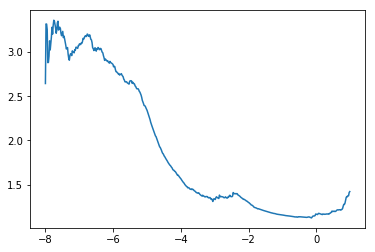

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.plot(log_lrs, losses)

In [12]:
NUM_EPOCH = 15
TOTAL_ITER = NUM_EPOCH * len(train_labels)/BATCH_SIZE
LR_MAX = 3e-4
LR_RATIO = 32
lr = slanted_triangular_learning_rate(TOTAL_ITER, 1/NUM_EPOCH, LR_MAX, LR_RATIO)
for _ in range(NUM_EPOCH):
    my_trainer.train_step_classifier(train_chars, train_labels, BATCH_SIZE, lr, BPTT, [0, 50, 200], fine_tune_rate=[RATIO, RATIO1, RATIO1, RATIO], folder_name=TRAIN_FOLDER)

Step    1: loss: 2.35911, acc: 0.60000, bptt:  64, time 04.79
Step    2: loss: 4.00419, acc: 0.40000, bptt:  66, time 05.90
Step    3: loss: 3.69487, acc: 0.40000, bptt:  34, time 06.85
Step    4: loss: 0.01138, acc: 1.00000, bptt:  28, time 07.84
Step    5: loss: 3.63279, acc: 0.40000, bptt:  76, time 08.78
Step    6: loss: 2.46706, acc: 0.40000, bptt:  70, time 09.39
Step    7: loss: 2.72052, acc: 0.30000, bptt:  71, time 09.93
Step    8: loss: 2.60666, acc: 0.40000, bptt:  67, time 10.40
Step    9: loss: 1.40695, acc: 0.60000, bptt:  70, time 10.91
Step   10: loss: 1.62181, acc: 0.60000, bptt:  72, time 11.37
Step   11: loss: 2.69885, acc: 0.20000, bptt:  68, time 11.82
Step   12: loss: 1.68020, acc: 0.50000, bptt:  73, time 12.34
Step   13: loss: 1.13747, acc: 0.60000, bptt:  71, time 12.70
Step   14: loss: 1.98788, acc: 0.20000, bptt:  76, time 13.26
Step   15: loss: 1.31259, acc: 0.40000, bptt:  74, time 13.71
Step   16: loss: 1.30314, acc: 0.50000, bptt:  67, time 14.08
Step   1

Ignoring: 102_sa/checkpoints/tmp; No such file or directory
Step  101: loss: 1.00331, acc: 0.60000, bptt:  61, time 52.01
Step  102: loss: 1.01835, acc: 0.40000, bptt:  71, time 52.14
Step  103: loss: 0.96933, acc: 0.70000, bptt:  77, time 52.30
Step  104: loss: 1.16104, acc: 0.40000, bptt:  71, time 52.45
Step  105: loss: 1.33966, acc: 0.30000, bptt:  64, time 52.60
Step  106: loss: 0.94299, acc: 0.60000, bptt:  76, time 52.76
Step  107: loss: 1.15536, acc: 0.50000, bptt:  61, time 52.88
Step  108: loss: 0.94492, acc: 0.60000, bptt:  72, time 53.02
Step  109: loss: 1.14697, acc: 0.40000, bptt:  67, time 53.17
Step  110: loss: 1.03880, acc: 0.40000, bptt:  66, time 53.30
Step  111: loss: 1.17770, acc: 0.50000, bptt:  71, time 53.43
Step  112: loss: 0.96499, acc: 0.70000, bptt:  79, time 53.55
Step  113: loss: 1.01730, acc: 0.30000, bptt:  65, time 53.70
Step  114: loss: 1.22567, acc: 0.30000, bptt:  60, time 53.86
Step  115: loss: 1.24583, acc: 0.10000, bptt:  84, time 54.00
Step  116:

Step  233: loss: 0.66836, acc: 0.80000, bptt:  70, time 74.82
Step  234: loss: 0.81754, acc: 0.60000, bptt:  73, time 74.95
Step  235: loss: 0.66755, acc: 0.80000, bptt:  72, time 75.10
Step  236: loss: 0.98231, acc: 0.60000, bptt:  68, time 75.24
Step  237: loss: 0.93099, acc: 0.60000, bptt:  84, time 75.38
Step  238: loss: 0.89835, acc: 0.60000, bptt:  65, time 75.54
Step  239: loss: 0.43534, acc: 1.00000, bptt:  69, time 75.71
Step  240: loss: 0.98321, acc: 0.50000, bptt:  71, time 75.86
Step  241: loss: 0.91154, acc: 0.70000, bptt:  60, time 75.98
Step  242: loss: 1.03155, acc: 0.60000, bptt:  68, time 76.14
Step  243: loss: 0.79308, acc: 0.60000, bptt:  74, time 76.30
Step  244: loss: 0.61573, acc: 0.80000, bptt:  70, time 76.46
Step  245: loss: 0.74230, acc: 0.60000, bptt:  63, time 76.59
Step  246: loss: 1.12965, acc: 0.60000, bptt:  70, time 76.74
Step  247: loss: 0.71832, acc: 0.70000, bptt:  40, time 76.91
Step  248: loss: 0.63913, acc: 0.70000, bptt:  76, time 77.08
Step  24

Step  365: loss: 0.55189, acc: 0.80000, bptt:  73, time 104.65
Step  366: loss: 1.01172, acc: 0.60000, bptt:  72, time 104.77
Step  367: loss: 0.60043, acc: 0.80000, bptt:  68, time 104.91
Step  368: loss: 0.77400, acc: 0.70000, bptt:  68, time 105.06
Step  369: loss: 1.28543, acc: 0.70000, bptt:  65, time 105.23
Step  370: loss: 1.04503, acc: 0.60000, bptt:  79, time 105.37
Step  371: loss: 1.01512, acc: 0.50000, bptt:  77, time 105.53
Step  372: loss: 0.61821, acc: 0.70000, bptt:  82, time 105.63
Step  373: loss: 0.51255, acc: 0.80000, bptt:  70, time 105.75
Step  374: loss: 1.01482, acc: 0.50000, bptt:  64, time 105.86
Step  375: loss: 1.07139, acc: 0.50000, bptt:  65, time 106.02
Step  376: loss: 0.59033, acc: 0.80000, bptt:  74, time 106.13
Step  377: loss: 0.57103, acc: 0.70000, bptt:  71, time 106.28
Step  378: loss: 0.82782, acc: 0.40000, bptt:  66, time 106.43
Step  379: loss: 0.86414, acc: 0.80000, bptt:  64, time 106.57
Step  380: loss: 0.78038, acc: 0.50000, bptt:  72, time

Step  496: loss: 0.79322, acc: 0.60000, bptt:  77, time 125.76
Step  497: loss: 0.91825, acc: 0.50000, bptt:  74, time 125.89
Step  498: loss: 0.95456, acc: 0.50000, bptt:  74, time 126.04
Step  499: loss: 1.06968, acc: 0.50000, bptt:  74, time 126.19
Step  500: loss: 0.66805, acc: 0.70000, bptt:  77, time 126.34
Step  501: loss: 1.15067, acc: 0.40000, bptt:  74, time 128.16
Step  502: loss: 0.78889, acc: 0.70000, bptt:  70, time 128.27
Step  503: loss: 0.72304, acc: 0.70000, bptt:  73, time 128.39
Step  504: loss: 1.17804, acc: 0.30000, bptt:  70, time 128.54
Step  505: loss: 0.97710, acc: 0.60000, bptt:  67, time 128.70
Step  506: loss: 1.12726, acc: 0.40000, bptt:  81, time 128.80
Step  507: loss: 1.03302, acc: 0.50000, bptt:  69, time 128.96
Step  508: loss: 0.56013, acc: 0.70000, bptt:  67, time 129.11
Step  509: loss: 1.09660, acc: 0.50000, bptt:  71, time 129.24
Step  510: loss: 0.88140, acc: 0.70000, bptt:  71, time 129.38
Step  511: loss: 0.59188, acc: 0.80000, bptt:  64, time

Step  628: loss: 1.03729, acc: 0.20000, bptt:  65, time 19.95
Step  629: loss: 0.67886, acc: 0.70000, bptt:  54, time 20.07
Step  630: loss: 0.48734, acc: 0.90000, bptt:  76, time 20.23
Step  631: loss: 0.43884, acc: 0.80000, bptt:  78, time 20.37
Step  632: loss: 0.58969, acc: 0.60000, bptt:  26, time 20.57
Step  633: loss: 1.05614, acc: 0.60000, bptt:  70, time 20.69
Step  634: loss: 1.36881, acc: 0.40000, bptt:  70, time 20.84
Step  635: loss: 0.69855, acc: 0.70000, bptt:  63, time 20.98
Step  636: loss: 0.64622, acc: 0.60000, bptt:  73, time 21.15
Step  637: loss: 0.92739, acc: 0.60000, bptt:  71, time 21.26
Step  638: loss: 0.61004, acc: 0.70000, bptt:  31, time 21.45
Step  639: loss: 0.81974, acc: 0.60000, bptt:  69, time 21.56
Step  640: loss: 0.55612, acc: 0.80000, bptt:  75, time 21.71
Step  641: loss: 1.09413, acc: 0.50000, bptt:  72, time 21.86
Step  642: loss: 0.62891, acc: 0.90000, bptt:  65, time 22.00
Step  643: loss: 0.34642, acc: 0.90000, bptt:  76, time 22.16
Step  64

Step  761: loss: 0.62827, acc: 0.70000, bptt:  68, time 47.92
Step  762: loss: 0.65412, acc: 0.80000, bptt:  69, time 48.08
Step  763: loss: 0.35409, acc: 0.90000, bptt:  81, time 48.20
Step  764: loss: 0.68741, acc: 0.70000, bptt:  79, time 48.33
Step  765: loss: 0.53628, acc: 0.80000, bptt:  72, time 48.48
Step  766: loss: 0.40494, acc: 0.80000, bptt:  70, time 48.63
Step  767: loss: 0.84133, acc: 0.70000, bptt:  56, time 48.77
Step  768: loss: 0.52845, acc: 0.80000, bptt:  70, time 48.92
Step  769: loss: 0.68137, acc: 0.70000, bptt:  66, time 49.05
Step  770: loss: 1.00601, acc: 0.60000, bptt:  72, time 49.18
Step  771: loss: 0.90426, acc: 0.80000, bptt:  70, time 49.33
Step  772: loss: 0.35076, acc: 0.90000, bptt:  78, time 49.47
Step  773: loss: 1.05803, acc: 0.50000, bptt:  70, time 49.61
Step  774: loss: 0.38970, acc: 0.70000, bptt:  74, time 49.76
Step  775: loss: 0.53487, acc: 0.70000, bptt:  69, time 49.90
Step  776: loss: 0.70417, acc: 0.70000, bptt:  84, time 50.03
Step  77

Step  894: loss: 0.45186, acc: 0.80000, bptt:  70, time 71.72
Step  895: loss: 0.50698, acc: 0.70000, bptt:  71, time 71.88
Step  896: loss: 0.33829, acc: 0.90000, bptt:  65, time 72.01
Step  897: loss: 0.60329, acc: 0.70000, bptt:  73, time 72.16
Step  898: loss: 0.37675, acc: 0.90000, bptt:  72, time 72.30
Step  899: loss: 0.92740, acc: 0.60000, bptt:  67, time 72.42
Step  900: loss: 0.72465, acc: 0.60000, bptt:  76, time 72.58
Step  901: loss: 0.82456, acc: 0.60000, bptt:  59, time 74.40
Step  902: loss: 0.95084, acc: 0.50000, bptt:  70, time 74.52
Step  903: loss: 0.95717, acc: 0.40000, bptt:  70, time 74.68
Step  904: loss: 0.80330, acc: 0.60000, bptt:  66, time 74.82
Step  905: loss: 0.84874, acc: 0.50000, bptt:  75, time 74.97
Step  906: loss: 0.63776, acc: 0.70000, bptt:  73, time 75.12
Step  907: loss: 0.70677, acc: 0.70000, bptt:  68, time 75.23
Step  908: loss: 0.53422, acc: 0.80000, bptt:  76, time 75.37
Step  909: loss: 0.75827, acc: 0.70000, bptt:  70, time 75.49
Step  91

Step 1026: loss: 0.65262, acc: 0.70000, bptt:  65, time 00.82
Step 1027: loss: 0.69674, acc: 0.60000, bptt:  66, time 00.98
Step 1028: loss: 0.43178, acc: 1.00000, bptt:  74, time 01.13
Step 1029: loss: 0.72751, acc: 0.80000, bptt:  72, time 01.30
Step 1030: loss: 0.71830, acc: 0.80000, bptt:  78, time 01.44
Step 1031: loss: 0.71779, acc: 0.70000, bptt:  70, time 01.73
Step 1032: loss: 0.92294, acc: 0.70000, bptt:  75, time 01.88
Step 1033: loss: 0.66561, acc: 0.70000, bptt:  66, time 02.00
Step 1034: loss: 0.44437, acc: 0.90000, bptt:  75, time 02.17
Step 1035: loss: 0.51054, acc: 0.90000, bptt:  68, time 02.32
Step 1036: loss: 0.72656, acc: 0.70000, bptt:  68, time 02.49
Step 1037: loss: 0.68110, acc: 0.70000, bptt:  68, time 02.64
Step 1038: loss: 0.64259, acc: 0.80000, bptt:  69, time 02.79
Step 1039: loss: 0.70392, acc: 0.70000, bptt:  76, time 02.94
Step 1040: loss: 0.65726, acc: 0.80000, bptt:  68, time 03.09
Step 1041: loss: 0.71328, acc: 0.60000, bptt:  71, time 03.25
Step 104

Step 1159: loss: 0.32908, acc: 0.90000, bptt:  73, time 24.71
Step 1160: loss: 0.28257, acc: 0.90000, bptt:  75, time 24.83
Step 1161: loss: 0.93676, acc: 0.70000, bptt:  65, time 24.96
Step 1162: loss: 1.28539, acc: 0.50000, bptt:  71, time 25.09
Step 1163: loss: 1.06636, acc: 0.70000, bptt:  70, time 25.21
Step 1164: loss: 0.39454, acc: 0.90000, bptt:  61, time 25.34
Step 1165: loss: 0.85960, acc: 0.50000, bptt:  76, time 25.50
Step 1166: loss: 0.72890, acc: 0.60000, bptt:  76, time 25.65
Step 1167: loss: 1.95004, acc: 0.50000, bptt:  68, time 25.77
Step 1168: loss: 0.92818, acc: 0.70000, bptt:  70, time 25.94
Step 1169: loss: 1.34221, acc: 0.40000, bptt:  66, time 26.08
Step 1170: loss: 0.50950, acc: 0.90000, bptt:  62, time 26.21
Step 1171: loss: 0.33799, acc: 0.90000, bptt:  73, time 26.31
Step 1172: loss: 0.63025, acc: 0.70000, bptt:  65, time 26.46
Step 1173: loss: 0.70772, acc: 0.50000, bptt:  70, time 26.62
Step 1174: loss: 0.75020, acc: 0.70000, bptt:  70, time 26.75
Step 117

Step 1292: loss: 0.60491, acc: 0.80000, bptt:  68, time 49.69
Step 1293: loss: 0.49050, acc: 0.80000, bptt:  67, time 49.82
Step 1294: loss: 0.41415, acc: 0.80000, bptt:  60, time 49.97
Step 1295: loss: 0.36940, acc: 0.80000, bptt:  66, time 50.13
Step 1296: loss: 1.25990, acc: 0.50000, bptt:  72, time 50.28
Step 1297: loss: 0.59361, acc: 0.80000, bptt:  72, time 50.44
Step 1298: loss: 0.47810, acc: 0.80000, bptt:  72, time 50.59
Step 1299: loss: 0.51268, acc: 0.70000, bptt:  72, time 50.72
Step 1300: loss: 0.37693, acc: 0.90000, bptt:  68, time 50.86
Step 1301: loss: 0.62450, acc: 0.80000, bptt:  65, time 52.65
Step 1302: loss: 0.32046, acc: 0.70000, bptt:  72, time 52.79
Step 1303: loss: 0.46466, acc: 0.70000, bptt:  70, time 52.95
Step 1304: loss: 0.47992, acc: 0.80000, bptt:  68, time 53.10
Step 1305: loss: 0.77537, acc: 0.80000, bptt:  70, time 53.23
Step 1306: loss: 0.33821, acc: 0.90000, bptt:  84, time 53.35
Step 1307: loss: 0.49284, acc: 0.80000, bptt:  68, time 53.50
Step 130

Step 1425: loss: 0.17548, acc: 1.00000, bptt:  70, time 73.63
Step 1426: loss: 0.76139, acc: 0.60000, bptt:  65, time 73.79
Step 1427: loss: 0.80419, acc: 0.60000, bptt:  75, time 73.92
Step 1428: loss: 0.09611, acc: 0.90000, bptt:  75, time 74.06
Step 1429: loss: 0.43264, acc: 0.80000, bptt:  70, time 74.22
Step 1430: loss: 0.59900, acc: 0.60000, bptt:  71, time 74.37
Step 1431: loss: 0.70360, acc: 0.60000, bptt:  63, time 74.52
Step 1432: loss: 1.51444, acc: 0.50000, bptt:  71, time 74.65
Step 1433: loss: 0.57648, acc: 0.90000, bptt:  69, time 74.79
Step 1434: loss: 0.72951, acc: 0.60000, bptt:  35, time 74.96
Step 1435: loss: 0.56286, acc: 0.70000, bptt:  72, time 75.12
Step 1436: loss: 0.26297, acc: 0.90000, bptt:  65, time 75.29
Step 1437: loss: 0.37508, acc: 0.90000, bptt:  72, time 75.49
Step 1438: loss: 1.17486, acc: 0.40000, bptt:  76, time 75.90
Step 1439: loss: 0.69075, acc: 0.80000, bptt:  67, time 76.23
Step 1440: loss: 0.99196, acc: 0.60000, bptt:  67, time 76.69
Step 144

Step 1557: loss: 0.47893, acc: 0.80000, bptt:  67, time 12.58
Step 1558: loss: 0.22749, acc: 0.90000, bptt:  70, time 12.93
Step 1559: loss: 0.42497, acc: 0.80000, bptt:  84, time 13.43
Step 1560: loss: 0.83604, acc: 0.70000, bptt:  69, time 14.00
Step 1561: loss: 0.20427, acc: 0.90000, bptt:  70, time 14.45
Step 1562: loss: 0.74279, acc: 0.80000, bptt:  71, time 14.91
Step 1563: loss: 0.58111, acc: 0.70000, bptt:  67, time 15.48
Step 1564: loss: 0.43385, acc: 0.80000, bptt:  73, time 16.11
Step 1565: loss: 1.05266, acc: 0.50000, bptt:  71, time 16.58
Step 1566: loss: 0.78727, acc: 0.70000, bptt:  66, time 17.04
Step 1567: loss: 0.36596, acc: 0.90000, bptt:  63, time 17.39
Step 1568: loss: 0.55557, acc: 0.60000, bptt:  70, time 17.83
Step 1569: loss: 0.47360, acc: 0.70000, bptt:  68, time 18.38
Step 1570: loss: 0.61191, acc: 0.70000, bptt:  80, time 18.95
Step 1571: loss: 0.83044, acc: 0.70000, bptt:  65, time 19.43
Step 1572: loss: 0.40547, acc: 0.80000, bptt:  70, time 19.82
Step 157

Step 1690: loss: 0.53499, acc: 0.80000, bptt:  60, time 53.06
Step 1691: loss: 0.51868, acc: 0.80000, bptt:  64, time 53.18
Step 1692: loss: 0.49541, acc: 0.80000, bptt:  73, time 53.34
Step 1693: loss: 0.31660, acc: 0.90000, bptt:  64, time 53.49
Step 1694: loss: 0.55409, acc: 0.70000, bptt:  72, time 53.64
Step 1695: loss: 1.48802, acc: 0.60000, bptt:  68, time 53.79
Step 1696: loss: 0.55767, acc: 0.70000, bptt:  66, time 53.91
Step 1697: loss: 0.46919, acc: 0.70000, bptt:  69, time 54.04
Step 1698: loss: 0.13397, acc: 1.00000, bptt:  35, time 54.22
Step 1699: loss: 0.24710, acc: 0.80000, bptt:  69, time 54.36
Step 1700: loss: 0.09971, acc: 1.00000, bptt:  70, time 54.51
Step 1701: loss: 0.58543, acc: 0.70000, bptt:  74, time 56.11
Step 1702: loss: 0.18487, acc: 1.00000, bptt:  76, time 56.24
Step 1703: loss: 0.41927, acc: 0.70000, bptt:  61, time 56.40
Step 1704: loss: 0.39108, acc: 0.80000, bptt:  83, time 56.55
Step 1705: loss: 0.43332, acc: 0.90000, bptt:  68, time 56.69
Step 170

Step 1823: loss: 0.29331, acc: 0.90000, bptt:  76, time 79.47
Step 1824: loss: 0.68158, acc: 0.70000, bptt:  72, time 79.63
Step 1825: loss: 0.61641, acc: 0.60000, bptt:  76, time 79.79
Step 1826: loss: 1.17118, acc: 0.60000, bptt:  73, time 79.91
Step 1827: loss: 0.29870, acc: 0.90000, bptt:  65, time 80.06
Step 1828: loss: 0.10153, acc: 1.00000, bptt:  71, time 80.22
Step 1829: loss: 0.45986, acc: 0.80000, bptt:  73, time 80.36
Step 1830: loss: 0.49587, acc: 0.90000, bptt:  76, time 80.49
Step 1831: loss: 0.82386, acc: 0.70000, bptt:  63, time 80.63
Step 1832: loss: 0.49125, acc: 0.70000, bptt:  79, time 80.78
Step 1833: loss: 0.13379, acc: 1.00000, bptt:  74, time 80.91
Step 1834: loss: 0.48671, acc: 0.80000, bptt:  70, time 81.07
Step 1835: loss: 0.18295, acc: 0.90000, bptt:  71, time 81.21
Step 1836: loss: 1.24583, acc: 0.50000, bptt:  73, time 81.35
Step 1837: loss: 0.06552, acc: 1.00000, bptt:  36, time 81.52
Step 1838: loss: 0.29497, acc: 0.90000, bptt:  66, time 81.68
Step 183

Step 1955: loss: 0.20271, acc: 1.00000, bptt:  36, time 106.17
Step 1956: loss: 0.25749, acc: 0.90000, bptt:  73, time 106.32
Step 1957: loss: 0.46143, acc: 0.80000, bptt:  69, time 106.49
Step 1958: loss: 0.42660, acc: 0.70000, bptt:  65, time 106.65
Step 1959: loss: 0.32192, acc: 0.90000, bptt:  63, time 106.79
Step 1960: loss: 0.59410, acc: 0.80000, bptt:  67, time 106.95
Step 1961: loss: 0.30206, acc: 0.90000, bptt:  71, time 107.08
Step 1962: loss: 0.24992, acc: 0.90000, bptt:  68, time 107.22
Step 1963: loss: 0.49647, acc: 0.80000, bptt:  65, time 107.37
Step 1964: loss: 0.61798, acc: 0.70000, bptt:  67, time 107.53
Step 1965: loss: 0.53675, acc: 0.80000, bptt:  71, time 107.68
Step 1966: loss: 0.18299, acc: 1.00000, bptt:  73, time 107.84
Step 1967: loss: 1.18442, acc: 0.70000, bptt:  70, time 107.96
Step 1968: loss: 0.33114, acc: 0.80000, bptt:  64, time 108.11
Step 1969: loss: 0.58859, acc: 0.80000, bptt:  76, time 108.22
Step 1970: loss: 0.65778, acc: 0.60000, bptt:  72, time

Step 2086: loss: 0.49302, acc: 0.90000, bptt:  69, time 07.82
Step 2087: loss: 0.70405, acc: 0.80000, bptt:  66, time 07.94
Step 2088: loss: 0.37138, acc: 0.90000, bptt:  77, time 08.10
Step 2089: loss: 0.38570, acc: 0.90000, bptt:  68, time 08.26
Step 2090: loss: 0.05967, acc: 1.00000, bptt:  63, time 08.51
Step 2091: loss: 0.09503, acc: 1.00000, bptt:  61, time 08.64
Step 2092: loss: 0.30184, acc: 0.90000, bptt:  68, time 08.80
Step 2093: loss: 0.58053, acc: 0.80000, bptt:  74, time 08.92
Step 2094: loss: 0.66794, acc: 0.80000, bptt:  75, time 09.08
Step 2095: loss: 0.44297, acc: 0.90000, bptt:  69, time 09.23
Step 2096: loss: 0.28540, acc: 0.90000, bptt:  62, time 09.38
Step 2097: loss: 0.78447, acc: 0.70000, bptt:  67, time 09.51
Step 2098: loss: 0.31261, acc: 0.90000, bptt:  71, time 09.65
Step 2099: loss: 0.06312, acc: 1.00000, bptt:  71, time 09.80
Step 2100: loss: 0.38840, acc: 0.90000, bptt:  70, time 09.94
Step 2101: loss: 0.19509, acc: 0.90000, bptt:  66, time 15.46
Step 210

Step 2219: loss: 0.15852, acc: 1.00000, bptt:  72, time 36.00
Step 2220: loss: 0.53541, acc: 0.70000, bptt:  65, time 36.16
Step 2221: loss: 0.38296, acc: 0.80000, bptt:  69, time 36.30
Step 2222: loss: 0.25474, acc: 0.90000, bptt:  69, time 36.41
Step 2223: loss: 0.56293, acc: 0.80000, bptt:  62, time 36.57
Step 2224: loss: 0.15449, acc: 1.00000, bptt:  40, time 36.67
Step 2225: loss: 0.04716, acc: 1.00000, bptt:  69, time 36.79
Step 2226: loss: 0.14079, acc: 1.00000, bptt:  73, time 36.93
Step 2227: loss: 0.14842, acc: 0.90000, bptt:  78, time 37.09
Step 2228: loss: 0.42340, acc: 0.80000, bptt:  75, time 37.22
Step 2229: loss: 0.22336, acc: 0.90000, bptt:  79, time 37.37
Step 2230: loss: 0.88013, acc: 0.80000, bptt:  74, time 37.53
Step 2231: loss: 0.06288, acc: 1.00000, bptt:  76, time 37.68
Step 2232: loss: 0.82133, acc: 0.70000, bptt:  69, time 37.84
Step 2233: loss: 0.62246, acc: 0.70000, bptt:  66, time 37.98
Step 2234: loss: 0.27191, acc: 0.90000, bptt:  59, time 38.10
Step 223

Step 2352: loss: 0.54063, acc: 0.80000, bptt:  69, time 61.19
Step 2353: loss: 0.50494, acc: 0.90000, bptt:  62, time 61.33
Step 2354: loss: 0.57840, acc: 0.80000, bptt:  66, time 61.47
Step 2355: loss: 0.04253, acc: 1.00000, bptt:  62, time 61.63
Step 2356: loss: 0.28600, acc: 0.80000, bptt:  67, time 61.77
Step 2357: loss: 0.40817, acc: 0.90000, bptt:  72, time 61.91
Step 2358: loss: 0.04603, acc: 1.00000, bptt:  71, time 62.07
Step 2359: loss: 0.13249, acc: 1.00000, bptt:  63, time 62.21
Step 2360: loss: 0.37832, acc: 0.80000, bptt:  61, time 62.35
Step 2361: loss: 0.09039, acc: 1.00000, bptt:  32, time 62.49
Step 2362: loss: 0.40744, acc: 0.80000, bptt:  75, time 62.64
Step 2363: loss: 0.37168, acc: 0.90000, bptt:  78, time 62.77
Step 2364: loss: 0.28156, acc: 0.90000, bptt:  59, time 62.91
Step 2365: loss: 0.05463, acc: 1.00000, bptt:  68, time 63.06
Step 2366: loss: 0.24911, acc: 1.00000, bptt:  70, time 63.21
Step 2367: loss: 0.16648, acc: 1.00000, bptt:  78, time 63.35
Step 236

Step 2485: loss: 1.19376, acc: 0.50000, bptt:  40, time 94.06
Step 2486: loss: 0.26991, acc: 0.90000, bptt:  63, time 94.60
Step 2487: loss: 0.41420, acc: 0.70000, bptt:  78, time 95.17
Step 2488: loss: 0.69665, acc: 0.70000, bptt:  72, time 95.68
Step 2489: loss: 0.60023, acc: 0.60000, bptt:  64, time 96.11
Step 2490: loss: 1.23610, acc: 0.60000, bptt:  67, time 96.41
Step 2491: loss: 0.84359, acc: 0.50000, bptt:  74, time 97.13
Step 2492: loss: 0.26328, acc: 1.00000, bptt:  67, time 97.66
Step 2493: loss: 0.66739, acc: 0.60000, bptt:  64, time 98.12
Step 2494: loss: 0.99618, acc: 0.70000, bptt:  67, time 98.65
Step 2495: loss: 0.92934, acc: 0.60000, bptt:  70, time 99.13
Step 2496: loss: 0.80515, acc: 0.60000, bptt:  73, time 99.64
Step 2497: loss: 1.46952, acc: 0.40000, bptt:  78, time 100.02
Step 2498: loss: 0.75178, acc: 0.60000, bptt:  70, time 100.91
Step 2499: loss: 0.72535, acc: 0.60000, bptt:  75, time 101.43
Step 2500: loss: 0.41295, acc: 0.90000, bptt:  69, time 101.86
Step

Step 2617: loss: 0.20580, acc: 1.00000, bptt:  72, time 14.40
Step 2618: loss: 0.27861, acc: 0.80000, bptt:  72, time 14.55
Step 2619: loss: 0.04731, acc: 1.00000, bptt:  69, time 14.68
Step 2620: loss: 0.06409, acc: 1.00000, bptt:  61, time 14.82
Step 2621: loss: 0.12011, acc: 0.90000, bptt:  62, time 14.97
Step 2622: loss: 0.07457, acc: 1.00000, bptt:  70, time 15.08
Step 2623: loss: 0.06041, acc: 1.00000, bptt:  75, time 15.20
Step 2624: loss: 0.21363, acc: 0.90000, bptt:  25, time 15.36
Step 2625: loss: 0.06330, acc: 1.00000, bptt:  65, time 15.51
Step 2626: loss: 0.40213, acc: 0.80000, bptt:  63, time 15.66
Step 2627: loss: 0.03729, acc: 1.00000, bptt:  79, time 15.81
Step 2628: loss: 0.22161, acc: 0.90000, bptt:  66, time 15.97
Step 2629: loss: 0.16815, acc: 0.90000, bptt:  67, time 16.10
Step 2630: loss: 0.12883, acc: 0.90000, bptt:  66, time 16.25
Step 2631: loss: 0.07956, acc: 1.00000, bptt:  67, time 16.40
Step 2632: loss: 0.05777, acc: 1.00000, bptt:  67, time 16.55
Step 263

Step 2750: loss: 0.38686, acc: 0.90000, bptt:  72, time 37.67
Step 2751: loss: 0.37861, acc: 0.80000, bptt:  70, time 41.28
Step 2752: loss: 0.12031, acc: 0.90000, bptt:  64, time 41.45
Step 2753: loss: 0.23648, acc: 0.90000, bptt:  57, time 41.58
Step 2754: loss: 0.11574, acc: 0.90000, bptt:  63, time 41.74
Step 2755: loss: 0.08983, acc: 1.00000, bptt:  72, time 41.90
Step 2756: loss: 0.47023, acc: 0.70000, bptt:  67, time 42.04
Step 2757: loss: 0.03297, acc: 1.00000, bptt:  73, time 42.20
Step 2758: loss: 0.42975, acc: 0.90000, bptt:  71, time 42.33
Step 2759: loss: 0.13363, acc: 1.00000, bptt:  72, time 42.49
Step 2760: loss: 0.14600, acc: 1.00000, bptt:  75, time 42.64
Step 2761: loss: 0.10298, acc: 1.00000, bptt:  80, time 42.77
Step 2762: loss: 0.53959, acc: 0.90000, bptt:  67, time 42.92
Step 2763: loss: 0.23480, acc: 0.90000, bptt:  72, time 43.07
Step 2764: loss: 0.15039, acc: 0.90000, bptt:  81, time 43.23
Step 2765: loss: 0.24507, acc: 0.90000, bptt:  67, time 43.39
Step 276

Step 2883: loss: 0.48716, acc: 0.70000, bptt:  68, time 63.15
Step 2884: loss: 0.02087, acc: 1.00000, bptt:  62, time 63.29
Step 2885: loss: 0.06155, acc: 1.00000, bptt:  71, time 63.40
Step 2886: loss: 0.07527, acc: 1.00000, bptt:  34, time 63.56
Step 2887: loss: 0.05383, acc: 1.00000, bptt:  70, time 63.72
Step 2888: loss: 0.42039, acc: 0.90000, bptt:  66, time 63.87
Step 2889: loss: 0.14491, acc: 0.90000, bptt:  74, time 64.02
Step 2890: loss: 0.16401, acc: 0.90000, bptt:  73, time 64.19
Step 2891: loss: 0.02603, acc: 1.00000, bptt:  72, time 64.29
Step 2892: loss: 0.06814, acc: 1.00000, bptt:  68, time 64.43
Step 2893: loss: 0.09530, acc: 0.90000, bptt:  70, time 64.57
Step 2894: loss: 0.10911, acc: 1.00000, bptt:  70, time 64.73
Step 2895: loss: 0.14043, acc: 1.00000, bptt:  69, time 64.89
Step 2896: loss: 0.50777, acc: 0.80000, bptt:  70, time 65.03
Step 2897: loss: 0.05966, acc: 1.00000, bptt:  75, time 65.19
Step 2898: loss: 0.40507, acc: 0.80000, bptt:  63, time 65.34
Step 289

Step 3016: loss: 0.06434, acc: 1.00000, bptt:  74, time 103.52
Step 3017: loss: 0.60957, acc: 0.70000, bptt:  71, time 103.78
Step 3018: loss: 0.34625, acc: 0.90000, bptt:  66, time 104.24
Step 3019: loss: 0.19575, acc: 1.00000, bptt:  70, time 104.68
Step 3020: loss: 0.39460, acc: 0.80000, bptt:  39, time 105.39
Step 3021: loss: 0.83762, acc: 0.80000, bptt:  68, time 105.79
Step 3022: loss: 0.59154, acc: 0.90000, bptt:  64, time 106.23
Step 3023: loss: 0.79403, acc: 0.80000, bptt:  74, time 106.57
Step 3024: loss: 0.37254, acc: 0.80000, bptt:  70, time 107.00
Step 3025: loss: 0.40319, acc: 0.80000, bptt:  63, time 107.35
Step 3026: loss: 0.18012, acc: 1.00000, bptt:  70, time 107.74
Step 3027: loss: 0.55016, acc: 0.90000, bptt:  75, time 108.15
Step 3028: loss: 0.26787, acc: 0.90000, bptt:  78, time 108.58
Step 3029: loss: 0.12767, acc: 0.90000, bptt:  67, time 109.03
Step 3030: loss: 0.60117, acc: 0.80000, bptt:  35, time 109.49
Step 3031: loss: 0.30498, acc: 0.80000, bptt:  66, time

Step 3148: loss: 0.17203, acc: 1.00000, bptt:  65, time 14.17
Step 3149: loss: 0.12475, acc: 0.90000, bptt:  69, time 14.33
Step 3150: loss: 0.14653, acc: 1.00000, bptt:  65, time 14.48
Step 3151: loss: 0.03238, acc: 1.00000, bptt:  62, time 18.88
Step 3152: loss: 0.14757, acc: 0.90000, bptt:  68, time 19.01
Step 3153: loss: 0.02047, acc: 1.00000, bptt:  68, time 19.16
Step 3154: loss: 0.08926, acc: 1.00000, bptt:  63, time 19.30
Step 3155: loss: 0.41799, acc: 0.90000, bptt:  70, time 19.42
Step 3156: loss: 0.11416, acc: 0.90000, bptt:  77, time 19.57
Step 3157: loss: 0.01156, acc: 1.00000, bptt:  73, time 19.74
Step 3158: loss: 0.17637, acc: 0.90000, bptt:  64, time 19.88
Step 3159: loss: 0.03632, acc: 1.00000, bptt:  73, time 20.03
Step 3160: loss: 0.10204, acc: 1.00000, bptt:  69, time 20.18
Step 3161: loss: 0.08042, acc: 1.00000, bptt:  66, time 20.35
Step 3162: loss: 0.07391, acc: 1.00000, bptt:  65, time 20.50
Step 3163: loss: 0.21202, acc: 0.80000, bptt:  65, time 20.64
Step 316

Step 3281: loss: 0.04150, acc: 1.00000, bptt:  72, time 40.81
Step 3282: loss: 0.11777, acc: 0.90000, bptt:  77, time 40.92
Step 3283: loss: 0.21998, acc: 0.90000, bptt:  71, time 41.03
Step 3284: loss: 0.17233, acc: 0.90000, bptt:  70, time 41.31
Step 3285: loss: 0.23680, acc: 0.80000, bptt:  71, time 41.46
Step 3286: loss: 0.00522, acc: 1.00000, bptt:  64, time 41.61
Step 3287: loss: 0.05134, acc: 1.00000, bptt:  68, time 41.76
Step 3288: loss: 0.01161, acc: 1.00000, bptt:  74, time 41.91
Step 3289: loss: 0.01949, acc: 1.00000, bptt:  68, time 42.06
Step 3290: loss: 0.03815, acc: 1.00000, bptt:  70, time 42.20
Step 3291: loss: 0.11989, acc: 1.00000, bptt:  67, time 42.34
Step 3292: loss: 0.30240, acc: 0.80000, bptt:  70, time 42.49
Step 3293: loss: 0.12240, acc: 0.90000, bptt:  65, time 42.62
Step 3294: loss: 0.06674, acc: 1.00000, bptt:  74, time 42.74
Step 3295: loss: 0.12052, acc: 0.90000, bptt:  77, time 42.89
Step 3296: loss: 0.45834, acc: 0.90000, bptt:  74, time 43.02
Step 329

Step 3414: loss: 0.01696, acc: 1.00000, bptt:  68, time 67.42
Step 3415: loss: 0.06938, acc: 1.00000, bptt:  84, time 67.55
Step 3416: loss: 0.04152, acc: 1.00000, bptt:  70, time 67.69
Step 3417: loss: 0.18439, acc: 1.00000, bptt:  67, time 67.82
Step 3418: loss: 0.44848, acc: 0.90000, bptt:  68, time 67.98
Step 3419: loss: 0.86755, acc: 0.90000, bptt:  64, time 68.14
Step 3420: loss: 0.02252, acc: 1.00000, bptt:  75, time 68.27
Step 3421: loss: 0.10726, acc: 1.00000, bptt:  80, time 68.42
Step 3422: loss: 0.00820, acc: 1.00000, bptt:  68, time 68.57
Step 3423: loss: 0.32996, acc: 0.90000, bptt:  73, time 68.69
Step 3424: loss: 0.32753, acc: 0.90000, bptt:  72, time 68.84
Step 3425: loss: 0.02781, acc: 1.00000, bptt:  71, time 68.99
Step 3426: loss: 0.24258, acc: 0.90000, bptt:  56, time 69.13
Step 3427: loss: 0.17871, acc: 0.90000, bptt:  72, time 69.29
Step 3428: loss: 0.37092, acc: 0.90000, bptt:  67, time 69.40
Step 3429: loss: 0.06043, acc: 1.00000, bptt:  71, time 69.55
Step 343

Step 3546: loss: 0.04799, acc: 1.00000, bptt:  39, time 111.00
Step 3547: loss: 0.15456, acc: 0.90000, bptt:  62, time 111.41
Step 3548: loss: 0.07458, acc: 1.00000, bptt:  74, time 111.83
Step 3549: loss: 0.22980, acc: 1.00000, bptt:  68, time 112.15
Step 3550: loss: 0.42173, acc: 0.80000, bptt:  75, time 112.67
Step 3551: loss: 0.07643, acc: 1.00000, bptt:  68, time 114.24
Step 3552: loss: 0.16119, acc: 0.90000, bptt:  70, time 114.81
Step 3553: loss: 0.14376, acc: 1.00000, bptt:  80, time 115.17
Step 3554: loss: 0.11393, acc: 0.90000, bptt:  60, time 115.73
Step 3555: loss: 0.10501, acc: 1.00000, bptt:  70, time 116.17
Step 3556: loss: 0.15303, acc: 0.90000, bptt:  75, time 116.49
Step 3557: loss: 0.03363, acc: 1.00000, bptt:  62, time 116.80
Step 3558: loss: 0.26513, acc: 0.90000, bptt:  67, time 117.25
Step 3559: loss: 0.52757, acc: 0.80000, bptt:  71, time 117.79
Step 3560: loss: 0.14489, acc: 0.90000, bptt:  73, time 118.12
Step 3561: loss: 0.58999, acc: 0.80000, bptt:  71, time

Step 3678: loss: 0.23462, acc: 0.90000, bptt:  70, time 48.16
Step 3679: loss: 0.14874, acc: 0.90000, bptt:  68, time 48.30
Step 3680: loss: 0.03911, acc: 1.00000, bptt:  74, time 48.45
Step 3681: loss: 0.02938, acc: 1.00000, bptt:  82, time 48.61
Step 3682: loss: 0.03087, acc: 1.00000, bptt:  67, time 48.76
Step 3683: loss: 0.01423, acc: 1.00000, bptt:  73, time 48.91
Step 3684: loss: 0.10254, acc: 0.90000, bptt:  65, time 49.06
Step 3685: loss: 0.15273, acc: 1.00000, bptt:  61, time 49.23
Step 3686: loss: 0.11254, acc: 1.00000, bptt:  72, time 49.34
Step 3687: loss: 0.00431, acc: 1.00000, bptt:  68, time 49.47
Step 3688: loss: 0.13490, acc: 1.00000, bptt:  71, time 49.61
Step 3689: loss: 0.06496, acc: 1.00000, bptt:  65, time 49.77
Step 3690: loss: 0.08412, acc: 1.00000, bptt:  73, time 49.91
Step 3691: loss: 0.01277, acc: 1.00000, bptt:  56, time 50.05
Step 3692: loss: 0.06160, acc: 1.00000, bptt:  39, time 50.24
Step 3693: loss: 0.15042, acc: 0.90000, bptt:  70, time 50.37
Step 369

Step 3811: loss: 0.02283, acc: 1.00000, bptt:  78, time 75.30
Step 3812: loss: 0.05529, acc: 1.00000, bptt:  66, time 75.44
Step 3813: loss: 0.00825, acc: 1.00000, bptt:  70, time 75.61
Step 3814: loss: 0.38310, acc: 0.80000, bptt:  65, time 75.75
Step 3815: loss: 0.27571, acc: 0.90000, bptt:  73, time 75.91
Step 3816: loss: 0.10002, acc: 1.00000, bptt:  65, time 76.07
Step 3817: loss: 0.01628, acc: 1.00000, bptt:  71, time 76.22
Step 3818: loss: 0.02887, acc: 1.00000, bptt:  66, time 76.34
Step 3819: loss: 0.33018, acc: 0.90000, bptt:  75, time 76.50
Step 3820: loss: 0.00756, acc: 1.00000, bptt:  67, time 76.64
Step 3821: loss: 0.00287, acc: 1.00000, bptt:  72, time 76.80
Step 3822: loss: 0.00270, acc: 1.00000, bptt:  68, time 76.96
Step 3823: loss: 0.03612, acc: 1.00000, bptt:  70, time 77.09
Step 3824: loss: 0.48912, acc: 0.80000, bptt:  63, time 77.33
Step 3825: loss: 0.01115, acc: 1.00000, bptt:  77, time 77.50
Step 3826: loss: 0.27010, acc: 0.90000, bptt:  62, time 77.61
Step 382

Step 3944: loss: 0.01613, acc: 1.00000, bptt:  76, time 96.88
Step 3945: loss: 0.25362, acc: 0.90000, bptt:  70, time 97.02
Step 3946: loss: 0.37328, acc: 0.80000, bptt:  72, time 97.17
Step 3947: loss: 0.00625, acc: 1.00000, bptt:  74, time 97.33
Step 3948: loss: 0.04451, acc: 1.00000, bptt:  69, time 97.49
Step 3949: loss: 0.09570, acc: 1.00000, bptt:  62, time 97.64
Step 3950: loss: 0.09855, acc: 1.00000, bptt:  78, time 97.80
Step 3951: loss: 0.16065, acc: 0.90000, bptt:  63, time 102.00
Step 3952: loss: 0.06516, acc: 1.00000, bptt:  71, time 102.14
Step 3953: loss: 0.01662, acc: 1.00000, bptt:  62, time 102.31
Step 3954: loss: 0.13170, acc: 0.90000, bptt:  33, time 102.46
Step 3955: loss: 0.00036, acc: 1.00000, bptt:  73, time 102.61
Step 3956: loss: 0.10982, acc: 0.90000, bptt:  67, time 102.75
Step 3957: loss: 0.40801, acc: 0.80000, bptt:  66, time 102.89
Step 3958: loss: 0.03972, acc: 1.00000, bptt:  63, time 103.05
Step 3959: loss: 0.02733, acc: 1.00000, bptt:  83, time 103.20

Step 4075: loss: 0.01676, acc: 1.00000, bptt:  70, time 126.56
Step 4076: loss: 0.30660, acc: 0.90000, bptt:  64, time 126.73
Step 4077: loss: 0.06224, acc: 1.00000, bptt:  61, time 126.83
Step 4078: loss: 0.01986, acc: 1.00000, bptt:  25, time 127.02
Step 4079: loss: 0.00150, acc: 1.00000, bptt:  75, time 127.16
Step 4080: loss: 0.25330, acc: 0.90000, bptt:  74, time 127.32
Step 4081: loss: 0.31281, acc: 0.90000, bptt:  67, time 01.14
Step 4082: loss: 0.14767, acc: 1.00000, bptt:  65, time 02.02
Step 4083: loss: 0.01240, acc: 1.00000, bptt:  66, time 02.89
Step 4084: loss: 0.03514, acc: 1.00000, bptt:  74, time 03.76
Step 4085: loss: 0.02381, acc: 1.00000, bptt:  31, time 04.73
Step 4086: loss: 0.00609, acc: 1.00000, bptt:  66, time 04.85
Step 4087: loss: 0.02781, acc: 1.00000, bptt:  75, time 04.99
Step 4088: loss: 0.09882, acc: 1.00000, bptt:  77, time 05.12
Step 4089: loss: 0.19964, acc: 0.90000, bptt:  71, time 05.26
Step 4090: loss: 0.02611, acc: 1.00000, bptt:  73, time 05.42
St

Step 4208: loss: 0.10721, acc: 0.90000, bptt:  73, time 29.88
Step 4209: loss: 0.00071, acc: 1.00000, bptt:  30, time 30.04
Step 4210: loss: 0.03851, acc: 1.00000, bptt:  74, time 30.18
Step 4211: loss: 0.00168, acc: 1.00000, bptt:  65, time 30.34
Step 4212: loss: 0.07282, acc: 1.00000, bptt:  65, time 30.47
Step 4213: loss: 0.01720, acc: 1.00000, bptt:  76, time 30.63
Step 4214: loss: 0.00610, acc: 1.00000, bptt:  67, time 30.76
Step 4215: loss: 0.00303, acc: 1.00000, bptt:  68, time 30.92
Step 4216: loss: 0.00150, acc: 1.00000, bptt:  71, time 31.06
Step 4217: loss: 0.00118, acc: 1.00000, bptt:  64, time 31.22
Step 4218: loss: 0.24133, acc: 0.90000, bptt:  67, time 31.37
Step 4219: loss: 0.01571, acc: 1.00000, bptt:  67, time 31.52
Step 4220: loss: 0.00371, acc: 1.00000, bptt:  68, time 31.66
Step 4221: loss: 0.00849, acc: 1.00000, bptt:  64, time 31.81
Step 4222: loss: 0.00476, acc: 1.00000, bptt:  71, time 31.93
Step 4223: loss: 0.00366, acc: 1.00000, bptt:  71, time 32.09
Step 422

Step 4341: loss: 0.02058, acc: 1.00000, bptt:  77, time 52.82
Step 4342: loss: 0.04979, acc: 1.00000, bptt:  36, time 52.97
Step 4343: loss: 0.02660, acc: 1.00000, bptt:  69, time 53.13
Step 4344: loss: 0.00132, acc: 1.00000, bptt:  75, time 53.25
Step 4345: loss: 0.08121, acc: 0.90000, bptt:  67, time 53.38
Step 4346: loss: 0.01598, acc: 1.00000, bptt:  67, time 53.54
Step 4347: loss: 0.43600, acc: 0.90000, bptt:  72, time 53.67
Step 4348: loss: 0.13803, acc: 0.90000, bptt:  67, time 53.83
Step 4349: loss: 0.17496, acc: 0.90000, bptt:  71, time 53.99
Step 4350: loss: 0.00316, acc: 1.00000, bptt:  80, time 54.14
Step 4351: loss: 0.54308, acc: 0.80000, bptt:  32, time 57.55
Step 4352: loss: 0.00670, acc: 1.00000, bptt:  74, time 57.68
Step 4353: loss: 0.02399, acc: 1.00000, bptt:  71, time 57.84
Step 4354: loss: 0.06303, acc: 1.00000, bptt:  67, time 57.99
Step 4355: loss: 0.00743, acc: 1.00000, bptt:  64, time 58.12
Step 4356: loss: 0.05935, acc: 1.00000, bptt:  77, time 58.27
Step 435

Step 4474: loss: 0.15588, acc: 0.90000, bptt:  72, time 78.17
Step 4475: loss: 0.01048, acc: 1.00000, bptt:  77, time 78.30
Step 4476: loss: 0.00971, acc: 1.00000, bptt:  27, time 78.48
Step 4477: loss: 0.14112, acc: 0.90000, bptt:  61, time 78.63
Step 4478: loss: 0.04624, acc: 1.00000, bptt:  59, time 78.78
Step 4479: loss: 0.03216, acc: 1.00000, bptt:  73, time 78.92
Step 4480: loss: 0.16068, acc: 0.90000, bptt:  70, time 79.07
Step 4481: loss: 0.02437, acc: 1.00000, bptt:  74, time 79.20
Step 4482: loss: 0.00898, acc: 1.00000, bptt:  66, time 79.35
Step 4483: loss: 0.02509, acc: 1.00000, bptt:  67, time 79.52
Step 4484: loss: 0.00145, acc: 1.00000, bptt:  70, time 79.61
Step 4485: loss: 0.23734, acc: 0.90000, bptt:  74, time 79.77
Step 4486: loss: 0.69335, acc: 0.80000, bptt:  27, time 79.95
Step 4487: loss: 0.02626, acc: 1.00000, bptt:  62, time 80.08
Step 4488: loss: 0.03598, acc: 1.00000, bptt:  30, time 80.25
Step 4489: loss: 0.00111, acc: 1.00000, bptt:  74, time 80.40
Step 449

Step 4606: loss: 0.07053, acc: 1.00000, bptt:  69, time 05.21
Step 4607: loss: 0.01075, acc: 1.00000, bptt:  72, time 05.37
Step 4608: loss: 0.00503, acc: 1.00000, bptt:  71, time 05.48
Step 4609: loss: 0.00205, acc: 1.00000, bptt:  65, time 05.61
Step 4610: loss: 0.59911, acc: 0.90000, bptt:  76, time 05.76
Step 4611: loss: 0.03136, acc: 1.00000, bptt:  61, time 05.89
Step 4612: loss: 0.01744, acc: 1.00000, bptt:  70, time 06.05
Step 4613: loss: 0.08340, acc: 1.00000, bptt:  63, time 06.19
Step 4614: loss: 0.10562, acc: 1.00000, bptt:  72, time 06.31
Step 4615: loss: 0.11237, acc: 0.90000, bptt:  75, time 06.44
Step 4616: loss: 0.04900, acc: 1.00000, bptt:  64, time 06.60
Step 4617: loss: 0.08259, acc: 1.00000, bptt:  30, time 06.74
Step 4618: loss: 0.00595, acc: 1.00000, bptt:  60, time 06.90
Step 4619: loss: 0.00842, acc: 1.00000, bptt:  65, time 07.05
Step 4620: loss: 0.01974, acc: 1.00000, bptt:  67, time 07.20
Step 4621: loss: 0.01456, acc: 1.00000, bptt:  73, time 07.35
Step 462

Step 4739: loss: 0.02017, acc: 1.00000, bptt:  72, time 29.27
Step 4740: loss: 0.07602, acc: 1.00000, bptt:  65, time 29.42
Step 4741: loss: 0.00456, acc: 1.00000, bptt:  57, time 29.57
Step 4742: loss: 0.01581, acc: 1.00000, bptt:  79, time 29.73
Step 4743: loss: 0.03426, acc: 1.00000, bptt:  66, time 29.88
Step 4744: loss: 0.00770, acc: 1.00000, bptt:  68, time 30.02
Step 4745: loss: 0.00622, acc: 1.00000, bptt:  58, time 30.17
Step 4746: loss: 0.02414, acc: 1.00000, bptt:  74, time 30.28
Step 4747: loss: 0.00557, acc: 1.00000, bptt:  71, time 30.44
Step 4748: loss: 0.02143, acc: 1.00000, bptt:  71, time 30.56
Step 4749: loss: 0.00084, acc: 1.00000, bptt:  64, time 30.70
Step 4750: loss: 0.27637, acc: 0.90000, bptt:  64, time 30.84
Step 4751: loss: 0.05820, acc: 1.00000, bptt:  30, time 32.71
Step 4752: loss: 0.03638, acc: 1.00000, bptt:  74, time 32.83
Step 4753: loss: 0.00420, acc: 1.00000, bptt:  63, time 32.97
Step 4754: loss: 0.05341, acc: 1.00000, bptt:  33, time 33.11
Step 475

Step 4872: loss: 0.00040, acc: 1.00000, bptt:  62, time 53.08
Step 4873: loss: 0.01893, acc: 1.00000, bptt:  73, time 53.19
Step 4874: loss: 0.01155, acc: 1.00000, bptt:  67, time 53.35
Step 4875: loss: 0.02579, acc: 1.00000, bptt:  78, time 53.51
Step 4876: loss: 0.00803, acc: 1.00000, bptt:  74, time 53.64
Step 4877: loss: 0.15331, acc: 0.90000, bptt:  62, time 53.77
Step 4878: loss: 0.01980, acc: 1.00000, bptt:  65, time 53.93
Step 4879: loss: 0.17398, acc: 0.90000, bptt:  64, time 54.08
Step 4880: loss: 0.00312, acc: 1.00000, bptt:  75, time 54.23
Step 4881: loss: 0.02664, acc: 1.00000, bptt:  70, time 54.38
Step 4882: loss: 0.00663, acc: 1.00000, bptt:  68, time 54.51
Step 4883: loss: 0.00844, acc: 1.00000, bptt:  76, time 54.66
Step 4884: loss: 0.00095, acc: 1.00000, bptt:  69, time 54.79
Step 4885: loss: 0.09901, acc: 0.90000, bptt:  67, time 54.95
Step 4886: loss: 0.02592, acc: 1.00000, bptt:  31, time 55.12
Step 4887: loss: 0.00019, acc: 1.00000, bptt:  67, time 55.27
Step 488

Step 5005: loss: 0.04360, acc: 1.00000, bptt:  64, time 79.25
Step 5006: loss: 0.00245, acc: 1.00000, bptt:  78, time 79.37
Step 5007: loss: 0.00130, acc: 1.00000, bptt:  66, time 79.90
Step 5008: loss: 0.00425, acc: 1.00000, bptt:  65, time 80.48
Step 5009: loss: 0.01647, acc: 1.00000, bptt:  66, time 80.93
Step 5010: loss: 0.01235, acc: 1.00000, bptt:  71, time 81.29
Step 5011: loss: 0.02872, acc: 1.00000, bptt:  80, time 81.55
Step 5012: loss: 0.10241, acc: 1.00000, bptt:  66, time 82.08
Step 5013: loss: 0.09168, acc: 0.90000, bptt:  72, time 82.45
Step 5014: loss: 0.04049, acc: 1.00000, bptt:  43, time 82.95
Step 5015: loss: 0.01726, acc: 1.00000, bptt:  63, time 83.28
Step 5016: loss: 0.09494, acc: 1.00000, bptt:  71, time 83.88
Step 5017: loss: 0.25779, acc: 0.90000, bptt:  67, time 84.31
Step 5018: loss: 0.17866, acc: 0.90000, bptt:  66, time 84.86
Step 5019: loss: 0.27519, acc: 0.90000, bptt:  75, time 85.38
Step 5020: loss: 0.05726, acc: 1.00000, bptt:  74, time 85.89
Step 502

Step 5137: loss: 0.01452, acc: 1.00000, bptt:  66, time 15.59
Step 5138: loss: 0.01468, acc: 1.00000, bptt:  73, time 15.90
Step 5139: loss: 0.00121, acc: 1.00000, bptt:  65, time 16.33
Step 5140: loss: 0.00451, acc: 1.00000, bptt:  68, time 16.81
Step 5141: loss: 0.17325, acc: 0.90000, bptt:  68, time 17.39
Step 5142: loss: 0.00468, acc: 1.00000, bptt:  69, time 17.93
Step 5143: loss: 0.29031, acc: 0.80000, bptt:  69, time 18.49
Step 5144: loss: 0.01687, acc: 1.00000, bptt:  68, time 18.89
Step 5145: loss: 0.00142, acc: 1.00000, bptt:  69, time 19.32
Step 5146: loss: 0.00196, acc: 1.00000, bptt:  41, time 19.70
Step 5147: loss: 0.01131, acc: 1.00000, bptt:  72, time 20.25
Step 5148: loss: 0.01949, acc: 1.00000, bptt:  76, time 20.58
Step 5149: loss: 0.00032, acc: 1.00000, bptt:  75, time 20.97
Step 5150: loss: 0.11119, acc: 0.90000, bptt:  84, time 21.32
Step 5151: loss: 0.04293, acc: 1.00000, bptt:  64, time 22.86
Step 5152: loss: 0.01113, acc: 1.00000, bptt:  70, time 23.33
Step 515

Step 5270: loss: 0.03293, acc: 1.00000, bptt:  70, time 57.28
Step 5271: loss: 0.03599, acc: 1.00000, bptt:  77, time 57.43
Step 5272: loss: 0.00502, acc: 1.00000, bptt:  78, time 57.59
Step 5273: loss: 0.02758, acc: 1.00000, bptt:  76, time 57.75
Step 5274: loss: 0.03242, acc: 1.00000, bptt:  75, time 57.90
Step 5275: loss: 0.01415, acc: 1.00000, bptt:  74, time 58.04
Step 5276: loss: 0.16696, acc: 0.90000, bptt:  74, time 58.15
Step 5277: loss: 0.00112, acc: 1.00000, bptt:  32, time 58.30
Step 5278: loss: 0.04272, acc: 1.00000, bptt:  79, time 58.42
Step 5279: loss: 0.05692, acc: 1.00000, bptt:  62, time 58.57
Step 5280: loss: 0.00109, acc: 1.00000, bptt:  78, time 58.70
Step 5281: loss: 0.01080, acc: 1.00000, bptt:  65, time 58.82
Step 5282: loss: 0.00933, acc: 1.00000, bptt:  72, time 58.95
Step 5283: loss: 0.04534, acc: 1.00000, bptt:  77, time 59.10
Step 5284: loss: 0.00013, acc: 1.00000, bptt:  75, time 59.24
Step 5285: loss: 0.00085, acc: 1.00000, bptt:  75, time 59.36
Step 528

Step 5403: loss: 0.01426, acc: 1.00000, bptt:  76, time 83.85
Step 5404: loss: 0.00289, acc: 1.00000, bptt:  26, time 84.00
Step 5405: loss: 0.05103, acc: 1.00000, bptt:  57, time 84.14
Step 5406: loss: 0.17121, acc: 0.90000, bptt:  64, time 84.27
Step 5407: loss: 0.01395, acc: 1.00000, bptt:  71, time 84.44
Step 5408: loss: 0.01584, acc: 1.00000, bptt:  67, time 84.57
Step 5409: loss: 0.00299, acc: 1.00000, bptt:  69, time 84.72
Step 5410: loss: 0.00485, acc: 1.00000, bptt:  40, time 84.86
Step 5411: loss: 0.09922, acc: 0.90000, bptt:  72, time 85.01
Step 5412: loss: 0.00327, acc: 1.00000, bptt:  66, time 85.17
Step 5413: loss: 0.00050, acc: 1.00000, bptt:  76, time 85.33
Step 5414: loss: 0.09597, acc: 0.90000, bptt:  68, time 85.47
Step 5415: loss: 0.00767, acc: 1.00000, bptt:  69, time 85.60
Step 5416: loss: 0.00028, acc: 1.00000, bptt:  63, time 85.76
Step 5417: loss: 0.01928, acc: 1.00000, bptt:  66, time 85.91
Step 5418: loss: 0.19535, acc: 0.90000, bptt:  80, time 86.02
Step 541

Step 5535: loss: 0.00079, acc: 1.00000, bptt:  67, time 106.40
Step 5536: loss: 0.00196, acc: 1.00000, bptt:  72, time 106.52
Step 5537: loss: 0.00013, acc: 1.00000, bptt:  73, time 106.67
Step 5538: loss: 0.00061, acc: 1.00000, bptt:  74, time 106.82
Step 5539: loss: 0.00021, acc: 1.00000, bptt:  71, time 106.96
Step 5540: loss: 0.02168, acc: 1.00000, bptt:  66, time 107.13
Step 5541: loss: 0.01591, acc: 1.00000, bptt:  64, time 107.28
Step 5542: loss: 0.00019, acc: 1.00000, bptt:  71, time 107.44
Step 5543: loss: 0.00156, acc: 1.00000, bptt:  68, time 107.61
Step 5544: loss: 0.13656, acc: 0.90000, bptt:  71, time 107.73
Step 5545: loss: 0.36170, acc: 0.90000, bptt:  72, time 107.88
Step 5546: loss: 0.00025, acc: 1.00000, bptt:  74, time 108.00
Step 5547: loss: 0.00034, acc: 1.00000, bptt:  62, time 108.15
Step 5548: loss: 0.19069, acc: 0.90000, bptt:  74, time 108.30
Step 5549: loss: 0.00392, acc: 1.00000, bptt:  73, time 108.46
Step 5550: loss: 0.00008, acc: 1.00000, bptt:  71, time

Step 5666: loss: 0.04938, acc: 1.00000, bptt:  65, time 26.05
Step 5667: loss: 0.00085, acc: 1.00000, bptt:  57, time 26.46
Step 5668: loss: 0.00654, acc: 1.00000, bptt:  65, time 26.92
Step 5669: loss: 0.02323, acc: 1.00000, bptt:  35, time 27.40
Step 5670: loss: 0.03451, acc: 1.00000, bptt:  64, time 27.80
Step 5671: loss: 0.07883, acc: 1.00000, bptt:  62, time 28.32
Step 5672: loss: 0.01688, acc: 1.00000, bptt:  56, time 28.77
Step 5673: loss: 0.00704, acc: 1.00000, bptt:  72, time 29.10
Step 5674: loss: 0.00550, acc: 1.00000, bptt:  68, time 29.65
Step 5675: loss: 0.01477, acc: 1.00000, bptt:  64, time 30.03
Step 5676: loss: 0.00059, acc: 1.00000, bptt:  66, time 30.59
Step 5677: loss: 0.01560, acc: 1.00000, bptt:  72, time 31.12
Step 5678: loss: 0.00017, acc: 1.00000, bptt:  74, time 31.53
Step 5679: loss: 0.00205, acc: 1.00000, bptt:  71, time 31.93
Step 5680: loss: 0.02240, acc: 1.00000, bptt:  74, time 32.32
Step 5681: loss: 0.01247, acc: 1.00000, bptt:  63, time 32.85
Step 568

Step 5799: loss: 0.01422, acc: 1.00000, bptt:  74, time 64.23
Step 5800: loss: 0.00086, acc: 1.00000, bptt:  67, time 64.35
Step 5801: loss: 0.00628, acc: 1.00000, bptt:  67, time 66.06
Step 5802: loss: 0.00074, acc: 1.00000, bptt:  71, time 66.18
Step 5803: loss: 0.00072, acc: 1.00000, bptt:  75, time 66.36
Step 5804: loss: 0.00031, acc: 1.00000, bptt:  35, time 66.48
Step 5805: loss: 0.00494, acc: 1.00000, bptt:  75, time 66.63
Step 5806: loss: 0.00240, acc: 1.00000, bptt:  68, time 66.76
Step 5807: loss: 0.02726, acc: 1.00000, bptt:  63, time 66.90
Step 5808: loss: 0.00051, acc: 1.00000, bptt:  66, time 67.04
Step 5809: loss: 0.02230, acc: 1.00000, bptt:  76, time 67.20
Step 5810: loss: 0.02174, acc: 1.00000, bptt:  70, time 67.35
Step 5811: loss: 0.00278, acc: 1.00000, bptt:  72, time 67.51
Step 5812: loss: 0.00237, acc: 1.00000, bptt:  64, time 67.64
Step 5813: loss: 0.00970, acc: 1.00000, bptt:  69, time 67.80
Step 5814: loss: 0.00132, acc: 1.00000, bptt:  75, time 67.95
Step 581

Step 5932: loss: 0.02155, acc: 1.00000, bptt:  69, time 89.08
Step 5933: loss: 0.04627, acc: 1.00000, bptt:  65, time 89.21
Step 5934: loss: 0.00026, acc: 1.00000, bptt:  73, time 89.34
Step 5935: loss: 0.00075, acc: 1.00000, bptt:  71, time 89.48
Step 5936: loss: 0.00032, acc: 1.00000, bptt:  68, time 89.63
Step 5937: loss: 0.00145, acc: 1.00000, bptt:  71, time 89.78
Step 5938: loss: 0.00069, acc: 1.00000, bptt:  64, time 89.90
Step 5939: loss: 0.04865, acc: 1.00000, bptt:  75, time 90.03
Step 5940: loss: 0.00569, acc: 1.00000, bptt:  71, time 90.18
Step 5941: loss: 0.00007, acc: 1.00000, bptt:  73, time 90.33
Step 5942: loss: 0.00093, acc: 1.00000, bptt:  70, time 90.46
Step 5943: loss: 0.03610, acc: 1.00000, bptt:  73, time 90.60
Step 5944: loss: 0.00053, acc: 1.00000, bptt:  62, time 90.71
Step 5945: loss: 0.00072, acc: 1.00000, bptt:  68, time 90.86
Step 5946: loss: 0.00163, acc: 1.00000, bptt:  62, time 90.98
Step 5947: loss: 0.01476, acc: 1.00000, bptt:  68, time 91.14
Step 594

Step 6063: loss: 0.01926, acc: 1.00000, bptt:  74, time 114.68
Step 6064: loss: 0.00017, acc: 1.00000, bptt:  65, time 114.84
Step 6065: loss: 0.08232, acc: 0.90000, bptt:  74, time 114.97
Step 6066: loss: 0.00223, acc: 1.00000, bptt:  71, time 115.13
Step 6067: loss: 0.00033, acc: 1.00000, bptt:  72, time 115.27
Step 6068: loss: 0.02081, acc: 1.00000, bptt:  69, time 115.40
Step 6069: loss: 0.00340, acc: 1.00000, bptt:  68, time 115.51
Step 6070: loss: 0.00186, acc: 1.00000, bptt:  60, time 115.64
Step 6071: loss: 0.00324, acc: 1.00000, bptt:  63, time 115.79
Step 6072: loss: 0.00231, acc: 1.00000, bptt:  63, time 115.94
Step 6073: loss: 0.01394, acc: 1.00000, bptt:  68, time 116.09
Step 6074: loss: 0.00075, acc: 1.00000, bptt:  72, time 116.24
Step 6075: loss: 0.00004, acc: 1.00000, bptt:  83, time 116.40
Step 6076: loss: 0.03450, acc: 1.00000, bptt:  72, time 116.55
Step 6077: loss: 0.00325, acc: 1.00000, bptt:  71, time 116.71
Step 6078: loss: 0.00098, acc: 1.00000, bptt:  68, time

Step 6195: loss: 0.00215, acc: 1.00000, bptt:  75, time 33.28
Step 6196: loss: 0.00672, acc: 1.00000, bptt:  66, time 33.63
Step 6197: loss: 0.00148, acc: 1.00000, bptt:  79, time 34.07
Step 6198: loss: 0.00023, acc: 1.00000, bptt:  74, time 34.39
Step 6199: loss: 0.00292, acc: 1.00000, bptt:  74, time 34.70
Step 6200: loss: 0.00755, acc: 1.00000, bptt:  67, time 35.14
Step 6201: loss: 0.11271, acc: 0.90000, bptt:  80, time 36.64
Step 6202: loss: 0.13244, acc: 0.90000, bptt:  64, time 37.14
Step 6203: loss: 0.00082, acc: 1.00000, bptt:  65, time 37.62
Step 6204: loss: 0.00041, acc: 1.00000, bptt:  67, time 37.93
Step 6205: loss: 0.00007, acc: 1.00000, bptt:  71, time 38.30
Step 6206: loss: 0.00390, acc: 1.00000, bptt:  70, time 38.82
Step 6207: loss: 0.00099, acc: 1.00000, bptt:  72, time 39.30
Step 6208: loss: 0.00050, acc: 1.00000, bptt:  72, time 39.83
Step 6209: loss: 0.05228, acc: 1.00000, bptt:  69, time 40.04
Step 6210: loss: 0.00211, acc: 1.00000, bptt:  25, time 40.20
Step 621

Step 6328: loss: 0.00136, acc: 1.00000, bptt:  64, time 63.99
Step 6329: loss: 0.08203, acc: 1.00000, bptt:  61, time 64.14
Step 6330: loss: 0.00180, acc: 1.00000, bptt:  81, time 64.30
Step 6331: loss: 0.00114, acc: 1.00000, bptt:  65, time 64.44
Step 6332: loss: 0.00169, acc: 1.00000, bptt:  68, time 64.59
Step 6333: loss: 0.00013, acc: 1.00000, bptt:  73, time 64.73
Step 6334: loss: 0.00633, acc: 1.00000, bptt:  71, time 64.86
Step 6335: loss: 0.00065, acc: 1.00000, bptt:  59, time 65.02
Step 6336: loss: 0.00008, acc: 1.00000, bptt:  35, time 65.19
Step 6337: loss: 0.00032, acc: 1.00000, bptt:  30, time 65.36
Step 6338: loss: 0.00185, acc: 1.00000, bptt:  72, time 65.52
Step 6339: loss: 0.00297, acc: 1.00000, bptt:  67, time 65.64
Step 6340: loss: 0.00041, acc: 1.00000, bptt:  65, time 65.76
Step 6341: loss: 0.00159, acc: 1.00000, bptt:  71, time 65.91
Step 6342: loss: 0.00400, acc: 1.00000, bptt:  56, time 66.06
Step 6343: loss: 0.00037, acc: 1.00000, bptt:  65, time 66.19
Step 634

Step 6461: loss: 0.00020, acc: 1.00000, bptt:  76, time 91.53
Step 6462: loss: 0.00017, acc: 1.00000, bptt:  31, time 91.70
Step 6463: loss: 0.06546, acc: 1.00000, bptt:  71, time 91.84
Step 6464: loss: 0.00748, acc: 1.00000, bptt:  66, time 91.99
Step 6465: loss: 0.00215, acc: 1.00000, bptt:  65, time 92.15
Step 6466: loss: 0.00088, acc: 1.00000, bptt:  33, time 92.26
Step 6467: loss: 0.00763, acc: 1.00000, bptt:  70, time 92.42
Step 6468: loss: 0.00130, acc: 1.00000, bptt:  68, time 92.54
Step 6469: loss: 0.24418, acc: 0.90000, bptt:  64, time 92.69
Step 6470: loss: 0.00216, acc: 1.00000, bptt:  74, time 92.85
Step 6471: loss: 0.00002, acc: 1.00000, bptt:  64, time 93.00
Step 6472: loss: 0.00014, acc: 1.00000, bptt:  33, time 93.15
Step 6473: loss: 0.00154, acc: 1.00000, bptt:  71, time 93.31
Step 6474: loss: 0.01957, acc: 1.00000, bptt:  66, time 93.43
Step 6475: loss: 0.00695, acc: 1.00000, bptt:  63, time 93.59
Step 6476: loss: 0.00178, acc: 1.00000, bptt:  70, time 93.73
Step 647

Step 6592: loss: 0.13339, acc: 0.90000, bptt:  76, time 112.72
Step 6593: loss: 0.00002, acc: 1.00000, bptt:  66, time 112.88
Step 6594: loss: 0.00069, acc: 1.00000, bptt:  61, time 113.02
Step 6595: loss: 0.00008, acc: 1.00000, bptt:  65, time 113.15
Step 6596: loss: 0.00029, acc: 1.00000, bptt:  69, time 113.30
Step 6597: loss: 0.00141, acc: 1.00000, bptt:  69, time 113.43
Step 6598: loss: 0.23319, acc: 0.90000, bptt:  74, time 113.59
Step 6599: loss: 0.00254, acc: 1.00000, bptt:  72, time 113.72
Step 6600: loss: 0.00009, acc: 1.00000, bptt:  64, time 113.84
Step 6601: loss: 0.01866, acc: 1.00000, bptt:  79, time 115.69
Step 6602: loss: 0.00554, acc: 1.00000, bptt:  71, time 115.85
Step 6603: loss: 0.00779, acc: 1.00000, bptt:  68, time 115.98
Step 6604: loss: 0.00731, acc: 1.00000, bptt:  68, time 116.12
Step 6605: loss: 0.00145, acc: 1.00000, bptt:  68, time 116.27
Step 6606: loss: 0.00017, acc: 1.00000, bptt:  65, time 116.40
Step 6607: loss: 0.00327, acc: 1.00000, bptt:  63, time

Step 6724: loss: 0.00868, acc: 1.00000, bptt:  73, time 43.09
Step 6725: loss: 0.00102, acc: 1.00000, bptt:  30, time 43.26
Step 6726: loss: 0.00036, acc: 1.00000, bptt:  67, time 43.39
Step 6727: loss: 0.00028, acc: 1.00000, bptt:  70, time 43.53
Step 6728: loss: 0.00274, acc: 1.00000, bptt:  38, time 43.69
Step 6729: loss: 0.00016, acc: 1.00000, bptt:  67, time 43.82
Step 6730: loss: 0.02066, acc: 1.00000, bptt:  69, time 43.98
Step 6731: loss: 0.00025, acc: 1.00000, bptt:  72, time 44.14
Step 6732: loss: 0.00151, acc: 1.00000, bptt:  69, time 44.30
Step 6733: loss: 0.00638, acc: 1.00000, bptt:  69, time 44.46
Step 6734: loss: 0.01387, acc: 1.00000, bptt:  66, time 44.60
Step 6735: loss: 0.00485, acc: 1.00000, bptt:  75, time 44.76
Step 6736: loss: 0.00016, acc: 1.00000, bptt:  65, time 44.91
Step 6737: loss: 0.00011, acc: 1.00000, bptt:  39, time 45.09
Step 6738: loss: 0.02975, acc: 1.00000, bptt:  65, time 45.25
Step 6739: loss: 0.00165, acc: 1.00000, bptt:  68, time 45.41
Step 674

Step 6857: loss: 0.00548, acc: 1.00000, bptt:  64, time 68.21
Step 6858: loss: 0.00046, acc: 1.00000, bptt:  72, time 68.36
Step 6859: loss: 0.00070, acc: 1.00000, bptt:  76, time 68.51
Step 6860: loss: 0.00009, acc: 1.00000, bptt:  71, time 68.66
Step 6861: loss: 0.00518, acc: 1.00000, bptt:  70, time 68.80
Step 6862: loss: 0.00275, acc: 1.00000, bptt:  67, time 68.92
Step 6863: loss: 0.00358, acc: 1.00000, bptt:  65, time 69.08
Step 6864: loss: 0.00561, acc: 1.00000, bptt:  67, time 69.20
Step 6865: loss: 0.00011, acc: 1.00000, bptt:  69, time 69.34
Step 6866: loss: 0.00240, acc: 1.00000, bptt:  74, time 69.50
Step 6867: loss: 0.00283, acc: 1.00000, bptt:  66, time 69.65
Step 6868: loss: 0.00225, acc: 1.00000, bptt:  68, time 69.80
Step 6869: loss: 0.02185, acc: 1.00000, bptt:  69, time 69.93
Step 6870: loss: 0.00005, acc: 1.00000, bptt:  73, time 70.08
Step 6871: loss: 0.00155, acc: 1.00000, bptt:  76, time 70.22
Step 6872: loss: 0.01887, acc: 1.00000, bptt:  68, time 70.36
Step 687

Step 6990: loss: 0.00024, acc: 1.00000, bptt:  69, time 90.06
Step 6991: loss: 0.00078, acc: 1.00000, bptt:  60, time 90.17
Step 6992: loss: 0.01531, acc: 1.00000, bptt:  61, time 90.29
Step 6993: loss: 0.04142, acc: 1.00000, bptt:  74, time 90.42
Step 6994: loss: 0.00017, acc: 1.00000, bptt:  70, time 90.57
Step 6995: loss: 0.00029, acc: 1.00000, bptt:  73, time 90.73
Step 6996: loss: 0.00017, acc: 1.00000, bptt:  74, time 90.87
Step 6997: loss: 0.00130, acc: 1.00000, bptt:  74, time 91.02
Step 6998: loss: 0.01575, acc: 1.00000, bptt:  33, time 91.18
Step 6999: loss: 0.00079, acc: 1.00000, bptt:  69, time 91.35
Step 7000: loss: 0.00193, acc: 1.00000, bptt:  72, time 91.48
Step 7001: loss: 0.00074, acc: 1.00000, bptt:  79, time 95.50
Step 7002: loss: 0.00282, acc: 1.00000, bptt:  75, time 95.64
Step 7003: loss: 0.01724, acc: 1.00000, bptt:  75, time 95.76
Step 7004: loss: 0.00000, acc: 1.00000, bptt:  65, time 95.90
Step 7005: loss: 0.00320, acc: 1.00000, bptt:  73, time 96.06
Step 700

Step 7121: loss: 0.00187, acc: 1.00000, bptt:  75, time 119.78
Step 7122: loss: 0.00509, acc: 1.00000, bptt:  68, time 119.93
Step 7123: loss: 0.25050, acc: 0.90000, bptt:  74, time 120.04
Step 7124: loss: 0.00010, acc: 1.00000, bptt:  73, time 120.19
Step 7125: loss: 0.00007, acc: 1.00000, bptt:  69, time 120.33
Step 7126: loss: 0.00037, acc: 1.00000, bptt:  74, time 120.45
Step 7127: loss: 0.00009, acc: 1.00000, bptt:  70, time 120.62
Step 7128: loss: 0.00002, acc: 1.00000, bptt:  65, time 120.74
Step 7129: loss: 0.14048, acc: 0.90000, bptt:  67, time 120.88
Step 7130: loss: 0.00001, acc: 1.00000, bptt:  66, time 121.02
Step 7131: loss: 0.00195, acc: 1.00000, bptt:  69, time 121.16
Step 7132: loss: 0.00542, acc: 1.00000, bptt:  63, time 121.29
Step 7133: loss: 0.00017, acc: 1.00000, bptt:  73, time 121.41
Step 7134: loss: 0.00094, acc: 1.00000, bptt:  64, time 121.55
Step 7135: loss: 0.00001, acc: 1.00000, bptt:  70, time 121.70
Step 7136: loss: 0.00121, acc: 1.00000, bptt:  65, time

Step 7253: loss: 0.00030, acc: 1.00000, bptt:  73, time 49.50
Step 7254: loss: 0.00019, acc: 1.00000, bptt:  62, time 49.66
Step 7255: loss: 0.04560, acc: 1.00000, bptt:  67, time 49.78
Step 7256: loss: 0.00027, acc: 1.00000, bptt:  67, time 49.94
Step 7257: loss: 0.00008, acc: 1.00000, bptt:  67, time 50.06
Step 7258: loss: 0.00002, acc: 1.00000, bptt:  68, time 50.16
Step 7259: loss: 0.00007, acc: 1.00000, bptt:  64, time 50.30
Step 7260: loss: 0.00195, acc: 1.00000, bptt:  64, time 50.45
Step 7261: loss: 0.00027, acc: 1.00000, bptt:  69, time 50.58
Step 7262: loss: 0.00433, acc: 1.00000, bptt:  68, time 50.69
Step 7263: loss: 0.00001, acc: 1.00000, bptt:  77, time 50.83
Step 7264: loss: 0.00125, acc: 1.00000, bptt:  77, time 50.98
Step 7265: loss: 0.00046, acc: 1.00000, bptt:  33, time 51.10
Step 7266: loss: 0.00286, acc: 1.00000, bptt:  62, time 51.25
Step 7267: loss: 0.00037, acc: 1.00000, bptt:  57, time 51.40
Step 7268: loss: 0.00205, acc: 1.00000, bptt:  64, time 51.54
Step 726

Step 7386: loss: 0.00009, acc: 1.00000, bptt:  72, time 72.20
Step 7387: loss: 0.00048, acc: 1.00000, bptt:  39, time 72.34
Step 7388: loss: 0.00004, acc: 1.00000, bptt:  73, time 72.47
Step 7389: loss: 0.00361, acc: 1.00000, bptt:  62, time 72.64
Step 7390: loss: 0.00397, acc: 1.00000, bptt:  70, time 72.79
Step 7391: loss: 0.00555, acc: 1.00000, bptt:  74, time 72.93
Step 7392: loss: 0.00082, acc: 1.00000, bptt:  69, time 73.08
Step 7393: loss: 0.00023, acc: 1.00000, bptt:  67, time 73.23
Step 7394: loss: 0.01596, acc: 1.00000, bptt:  68, time 73.39
Step 7395: loss: 0.00023, acc: 1.00000, bptt:  66, time 73.53
Step 7396: loss: 0.06011, acc: 1.00000, bptt:  75, time 73.67
Step 7397: loss: 0.00128, acc: 1.00000, bptt:  44, time 73.81
Step 7398: loss: 0.00116, acc: 1.00000, bptt:  80, time 73.97
Step 7399: loss: 0.00004, acc: 1.00000, bptt:  75, time 74.13
Step 7400: loss: 0.00008, acc: 1.00000, bptt:  74, time 74.27
Step 7401: loss: 0.00110, acc: 1.00000, bptt:  72, time 77.46
Step 740

Step 7519: loss: 0.00002, acc: 1.00000, bptt:  74, time 97.03
Step 7520: loss: 0.00071, acc: 1.00000, bptt:  68, time 97.16
Step 7521: loss: 0.00010, acc: 1.00000, bptt:  70, time 97.28
Step 7522: loss: 0.00011, acc: 1.00000, bptt:  76, time 97.44
Step 7523: loss: 0.00143, acc: 1.00000, bptt:  67, time 97.59
Step 7524: loss: 0.00007, acc: 1.00000, bptt:  70, time 97.70
Step 7525: loss: 0.00068, acc: 1.00000, bptt:  66, time 97.86
Step 7526: loss: 0.00013, acc: 1.00000, bptt:  69, time 98.00
Step 7527: loss: 0.00005, acc: 1.00000, bptt:  70, time 98.15
Step 7528: loss: 0.00000, acc: 1.00000, bptt:  71, time 98.27
Step 7529: loss: 0.00291, acc: 1.00000, bptt:  70, time 98.40
Step 7530: loss: 0.00001, acc: 1.00000, bptt:  69, time 98.54
Step 7531: loss: 0.00028, acc: 1.00000, bptt:  72, time 98.69
Step 7532: loss: 0.00039, acc: 1.00000, bptt:  75, time 98.84
Step 7533: loss: 0.00002, acc: 1.00000, bptt:  76, time 98.98
Step 7534: loss: 0.00035, acc: 1.00000, bptt:  68, time 99.10
Step 753

Step 7650: loss: 0.00019, acc: 1.00000, bptt:  68, time 124.76


In [13]:
from sklearn.metrics import classification_report

In [14]:
def eval_step_classifier(self, test_char, test_labels, batch_size, bptt, splits, folder_name='class_test'):
    import time
    import os
    start_time = time.time()
    save_path = os.path.join(self.checkpoint_dir, folder_name, 'model.cpkt')
    self.test_saver.save(self.session, save_path, global_step=self.session.run(self.global_step))
    total_loss = 0
    total_acc = 0
    count = 0
    predicts = []
    y_true = []
    for char_inputs, seq_lens, char_lens, true_labels in get_batch_classifier(test_char, test_labels, batch_size, splits, is_training=False):
        fd = {
            self.model_test.inputs: char_inputs, self.model_test.seq_lens: seq_lens,
            self.model_test.char_lens: char_lens, self.model_test.bptt: bptt,
            self.true_y: true_labels
        }
        y_pred, test_loss, test_acc = self.session.run([self.test_classifier.logits, self.test_loss, self.test_acc], feed_dict=fd)
        total_loss += test_loss * len(true_labels)
        total_acc += test_acc * len(true_labels)
        count += len(true_labels)
        predicts.append(y_pred)
        y_true.append(true_labels)
        print("Evaluate total loss: {:05.5f}, total acc: {:05.5f}, time {:05.2f}".format(total_loss/count, total_acc/count, time.time()-start_time))
    print(count)
    print(total_acc)
    return np.argmax(np.concatenate(predicts), axis=-1), np.concatenate(y_true)

In [15]:
y_pred, y_true = eval_step_classifier(my_trainer, test_chars, test_labels, 10, 20, [0, 50, 200], TEST_FOLDER)

Evaluate total loss: 3.54641, total acc: 0.50000, time 02.52
Evaluate total loss: 2.94706, total acc: 0.50000, time 02.77
Evaluate total loss: 2.48764, total acc: 0.53333, time 03.07
Evaluate total loss: 2.13895, total acc: 0.57500, time 03.25
Evaluate total loss: 1.91090, total acc: 0.64000, time 03.41
Evaluate total loss: 1.80591, total acc: 0.66667, time 03.61
Evaluate total loss: 1.75971, total acc: 0.65714, time 03.84
Evaluate total loss: 1.73733, total acc: 0.68750, time 04.00
Evaluate total loss: 2.01565, total acc: 0.67778, time 04.17
Evaluate total loss: 2.21050, total acc: 0.67000, time 04.49
Evaluate total loss: 2.24535, total acc: 0.67273, time 04.72
Evaluate total loss: 2.42081, total acc: 0.66667, time 04.90
Evaluate total loss: 2.46282, total acc: 0.66154, time 05.20
Evaluate total loss: 2.43888, total acc: 0.67143, time 05.39
Evaluate total loss: 2.41022, total acc: 0.65333, time 05.66
Evaluate total loss: 2.42913, total acc: 0.64375, time 05.82
Evaluate total loss: 2.4

In [16]:
print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70       350
           1       0.62      0.65      0.64       350
           2       0.79      0.75      0.77       350

   micro avg       0.70      0.70      0.70      1050
   macro avg       0.70      0.70      0.70      1050
weighted avg       0.70      0.70      0.70      1050

